In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.utils import functions, path
from spectrome.brain import Brain
import scipy.stats as stats
from scipy.stats import friedmanchisquare


from spectrome.forward import ntf_local_stimulus as nt_stim
from spectrome.forward import ntf_local as nt_nostim
from spectrome.forward import ntf_local_stimulus as nt_stim

from scipy.io import loadmat
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

import pickle as pkl

In [2]:
##all the sessions data of MEG
data1=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess1.mat")
data2=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess2.mat")
data3=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess3.mat")
data4=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_MEG_Sess4.mat")


##all the sessions mi 
sess1_mi_avg=data1['Avg_MI_MEG_DK']
sess2_mi_avg=data2['Avg_MI_MEG_DK']
sess3_mi_avg=data3['Avg_MI_MEG_DK']
sess4_mi_avg=data4['Avg_MI_EEG_DK']

##all the sessions resting state
sess1_rest_avg=data1['Avg_RS1_MEG_DK']
sess2_rest_avg=data2['Avg_RS1_MEG_DK']
sess3_rest_avg=data3['Avg_RS1_MEG_DK']
sess4_rest_avg=data4['Avg_RS1_EEG_DK']

##all the sessions baseline
sess1_base_avg=data1['Avg_Baseline_MEG_DK']
sess2_base_avg=data2['Avg_Baseline_MEG_DK']
sess3_base_avg=data3['Avg_Baseline_MEG_DK']
sess4_base_avg=data4['Avg_Baseline_EEG_DK']


In [3]:
scores=loadmat("../../../Performances_19Subj_4Sess.mat")
bci_score={}
for i in range(1,5):
    bci_score[i]=np.concatenate([arr.flatten() for arr in np.squeeze(loadmat("../../../Performances_19Subj_4Sess.mat")[f'Performance_Sess{i}'])])
    
df=pd.read_excel('../../../spectrome-bci/spectrome/ListROIs_DK.xlsx')
fvec=np.squeeze(data1["Freqs"])[3:30]

In [4]:
all_regions=[]
all_regions_idx=[]
for i,r in df.iterrows():
    all_regions_idx.append(i)
    all_regions.append(r['ROI'].strip("'"))

In [5]:
##modeled data
x_mi_all={}
x_base_all={}
x_rest_all={}

for num in range(1, 5):
    x_mi_all[num]=np.zeros((68, 10, 19))
    x_base_all[num]=np.zeros((68, 10, 19))
    x_rest_all[num]=np.zeros((68, 10, 19))
    
    for i in range(19):
        mi_fname = f'../bci_results_apd/bci_results/meg/sess{num}/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
        with open(mi_fname, 'rb') as f:
            x_mi_all[num][:,:,i]=np.array(pkl.load(f))

        base_fname = f'../bci_results_apd/bci_results/meg/sess{num}/baseline_allsubs_f/baseline_nostim_mse_db_fvec330_{i}.p'
        with open(base_fname, 'rb') as f:
            x_base_all[num][:,:,i] = np.array(pkl.load(f))
        
        rest_fname = f'../bci_results_apd/bci_results/meg/sess{num}/rs1_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
        with open(rest_fname, 'rb') as f:
            x_rest_all[num][:,:,i]=np.array(pkl.load(f))

In [ ]:
# x_rest_all[4][:,2,0]-x_mi_all[4][:,2,0]

### (MI-Rest)/Rest

In [7]:
##gei
sess1_mi_rest_gei=[[] for _ in range(68)]
sess2_mi_rest_gei=[[] for _ in range(68)]
sess3_mi_rest_gei=[[] for _ in range(68)]
sess4_mi_rest_gei=[[] for _ in range(68)]

 
for k in range(68):
  for j in range(19):
        mi_rest1_gei=(abs(x_mi_all[1][k,0,j])-abs(x_rest_all[1][k,0,j]))/abs(x_rest_all[1][k,0,j])
        sess1_mi_rest_gei[k].append(mi_rest1_gei)

        mi_rest2_gei=(abs(x_mi_all[2][k,0,j])-abs(x_rest_all[2][k,0,j]))/abs(x_rest_all[2][k,0,j])
        sess2_mi_rest_gei[k].append(mi_rest2_gei)

        mi_rest3_gei=(abs(x_mi_all[3][k,0,j])-abs(x_rest_all[3][k,0,j]))/abs(x_rest_all[3][k,0,j])
        sess3_mi_rest_gei[k].append(mi_rest3_gei)
        
        mi_rest4_gei=(abs(x_mi_all[4][k,0,j])-abs(x_rest_all[4][k,0,j]))/abs(x_rest_all[4][k,0,j])
        sess4_mi_rest_gei[k].append(mi_rest4_gei)

In [13]:
# for i in range(68):
#     if len(sess1_mi_rest_gei[i]) != 15:
#         print(i)

In [9]:
print("Incase of gei, significant regions are---")
for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_gei[i], sess2_mi_rest_gei[i], sess3_mi_rest_gei[i], sess4_mi_rest_gei[i])
    if result[1]<0.05:
        for j, reg in enumerate(all_regions):
            if i==j:
                print(f"index {i}, {all_regions[j]}, {result}")


Incase of gei, significant regions are---
index 9, entorhinal R, FriedmanchisquareResult(statistic=10.005405405405407, pvalue=0.018520243373910412)


In [10]:
p_values = []

for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_gei[i], sess2_mi_rest_gei[i], sess3_mi_rest_gei[i], sess4_mi_rest_gei[i])
    p_values.append(result[1])

fdr_corrected_pvals = fdrcorrection(p_values)[1]
fdr_corr = fdr_corrected_pvals.tolist()

for i in range(len(fdr_corr)):
    if fdr_corr[i] < 0.1:
        print(f"index {i}, {all_regions[i]}, {fdr_corr[i]}")

In [11]:
fdr_corrected_pvals

array([0.78170587, 0.79096724, 0.89161412, 0.84158303, 0.99000992,
       0.79995452, 0.79096724, 0.78170587, 0.79096724, 0.78170587,
       0.78170587, 0.79995452, 0.78170587, 0.79096724, 0.79096724,
       0.79096724, 0.7952096 , 0.79096724, 0.84766076, 0.78170587,
       0.85945888, 0.79096724, 0.79096724, 0.84766076, 0.79096724,
       0.79096724, 0.9484041 , 0.79096724, 0.99000992, 0.84158303,
       0.99000992, 0.99000992, 0.79096724, 0.99000992, 0.99000992,
       0.99000992, 0.83623298, 0.79995452, 0.79995452, 0.79096724,
       0.99000992, 0.79096724, 0.79995452, 0.78170587, 0.79096724,
       0.79096724, 0.79995452, 0.78170587, 0.79995452, 0.84158303,
       0.7952096 , 0.79995452, 0.78170587, 0.79995452, 0.79995452,
       0.79096724, 0.7952096 , 0.99000992, 0.78170587, 0.78170587,
       0.99000992, 0.79096724, 0.79995452, 0.79096724, 0.7952096 ,
       0.79096724, 0.79096724, 0.86709746])

In [12]:
##gii
sess1_mi_rest_gii=[[] for _ in range(68)]
sess2_mi_rest_gii=[[] for _ in range(68)]
sess3_mi_rest_gii=[[] for _ in range(68)]
sess4_mi_rest_gii=[[] for _ in range(68)]

 
for k in range(68):
    for j in range(19):
        mi_rest1_gii=((x_mi_all[1][k,1,j])-(x_rest_all[1][k,1,j]))/(x_rest_all[1][k,1,j])
        sess1_mi_rest_gii[k].append(mi_rest1_gii)
        mi_rest2_gii=((x_mi_all[2][k,1,j])-(x_rest_all[2][k,1,j]))/(x_rest_all[2][k,1,j])
        sess2_mi_rest_gii[k].append(mi_rest2_gii)
        mi_rest3_gii=((x_mi_all[3][k,1,j])-(x_rest_all[3][k,1,j]))/(x_rest_all[3][k,1,j])
        sess3_mi_rest_gii[k].append(mi_rest3_gii)
        mi_rest4_gii=((x_mi_all[4][k,1,j])-(x_rest_all[4][k,1,j]))/(x_rest_all[4][k,1,j])
        sess4_mi_rest_gii[k].append(mi_rest4_gii)


In [14]:
for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_gii[i], sess2_mi_rest_gii[i], sess3_mi_rest_gii[i], sess4_mi_rest_gii[i])
    # print(result[1])
    if result[1]<0.05:
        for j, reg in enumerate(all_regions):
            if i==j:
                print(f"index {i}, {all_regions[j]}, {result}")

In [15]:
p_values = []

for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_gii[i], sess2_mi_rest_gii[i], sess3_mi_rest_gii[i], sess4_mi_rest_gii[i])
    p_values.append(result[1])

fdr_corrected_pvals = fdrcorrection(p_values)[1]
fdr_corr = fdr_corrected_pvals.tolist()

for i in range(len(fdr_corr)):
    if fdr_corr[i] < 0.1:
        print(f"index {i}, {all_regions[i]}, {fdr_corr[i]}")

In [16]:
fdr_corrected_pvals

array([0.88784721, 0.88784721, 0.88784721, 0.96128261, 0.88784721,
       0.92640112, 0.90196146, 0.90366084, 0.90366084, 0.88784721,
       0.88784721, 0.88784721, 0.88784721, 0.88784721, 0.88784721,
       0.88784721, 0.88784721, 0.88784721, 0.88784721, 0.88784721,
       0.88784721, 0.88784721, 0.88784721, 0.99008941, 0.88784721,
       0.88784721, 0.90366084, 0.98162641, 0.88784721, 0.88784721,
       0.88784721, 0.95029669, 0.88784721, 0.88784721, 0.88784721,
       0.88784721, 0.96855329, 0.99008941, 0.88784721, 0.88784721,
       0.99008941, 0.88784721, 0.88784721, 0.95029669, 0.88784721,
       0.88784721, 0.88784721, 0.88784721, 0.99008941, 0.93755744,
       0.88784721, 0.88784721, 0.88784721, 0.88784721, 0.88784721,
       0.88784721, 0.88784721, 0.88784721, 0.88784721, 0.88784721,
       0.99008941, 0.88784721, 0.88784721, 0.93788986, 0.88784721,
       0.88784721, 0.88784721, 0.88784721])

In [17]:
##tau_e
sess1_mi_rest_tau_e=[[] for _ in range(68)]
sess2_mi_rest_tau_e=[[] for _ in range(68)]
sess3_mi_rest_tau_e=[[] for _ in range(68)]
sess4_mi_rest_tau_e=[[] for _ in range(68)]

 
for k in range(68):
    for j in range(19):
        mi_rest1_tau_e=((x_mi_all[1][k,2,j])-(x_rest_all[1][k,2,j]))/(x_rest_all[1][k,2,j])
        sess1_mi_rest_tau_e[k].append(mi_rest1_tau_e)
        mi_rest2_tau_e=((x_mi_all[2][k,2,j])-(x_rest_all[2][k,2,j]))/(x_rest_all[2][k,2,j])
        sess2_mi_rest_tau_e[k].append(mi_rest2_tau_e)
        mi_rest3_tau_e=((x_mi_all[3][k,2,j])-(x_rest_all[3][k,2,j]))/(x_rest_all[3][k,2,j])
        sess3_mi_rest_tau_e[k].append(mi_rest3_tau_e)
        mi_rest4_tau_e=((x_mi_all[4][k,2,j])-(x_rest_all[4][k,2,j]))/(x_rest_all[4][k,2,j])
        sess4_mi_rest_tau_e[k].append(mi_rest4_tau_e)

In [19]:
print("Incase of tau_e, significant regions are---")
for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_tau_e[i], sess2_mi_rest_tau_e[i], sess3_mi_rest_tau_e[i], sess4_mi_rest_tau_e[i])
    if result[1]<0.05:
        for j, reg in enumerate(all_regions):
            if i==j:
                print(f"index {i}, {all_regions[j]}, {result}")


Incase of tau_e, significant regions are---
index 17, inferiortemporal R, FriedmanchisquareResult(statistic=7.941176470588244, pvalue=0.047243183430928426)
index 31, middletemporal R, FriedmanchisquareResult(statistic=9.609890109890136, pvalue=0.02219059747469413)
index 33, paracentral R, FriedmanchisquareResult(statistic=9.634920634920661, pvalue=0.021938513471930935)
index 51, precuneus R, FriedmanchisquareResult(statistic=8.460317460317492, pvalue=0.03739727630985676)


In [20]:
p_values = []

for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_tau_e[i], sess2_mi_rest_tau_e[i], sess3_mi_rest_tau_e[i], sess4_mi_rest_tau_e[i])
    p_values.append(result[1])

fdr_corrected_pvals = fdrcorrection(p_values)[1]
fdr_corr = fdr_corrected_pvals.tolist()

for i in range(len(fdr_corr)):
    if fdr_corr[i] < 0.1:
        print(f"index {i}, {all_regions[i]}, {fdr_corr[i]}")

In [21]:
fdr_corrected_pvals

array([0.94955159, 0.94955159, 0.94955159, 0.94955159, 0.94955159,
       0.94955159, 0.94955159, 0.94758322, 0.94955159, 0.94955159,
       0.94955159, 0.94955159, 0.94955159, 0.94955159, 0.94955159,
       0.94955159, 0.94955159, 0.80313412, 0.94955159, 0.99727545,
       0.94955159, 0.94955159, 0.94955159, 0.94955159, 0.97838657,
       0.94955159, 0.94955159, 0.94955159, 0.99727545, 0.94955159,
       0.94758322, 0.75448031, 0.94955159, 0.75448031, 0.94955159,
       0.96368055, 0.99727545, 0.94955159, 0.99727545, 0.97838657,
       0.94955159, 0.94955159, 0.94955159, 0.97838657, 0.99727545,
       0.94955159, 0.97838657, 0.94955159, 0.94955159, 0.99727545,
       0.94955159, 0.80313412, 0.94955159, 0.94955159, 0.94955159,
       0.96519277, 0.94955159, 0.97838657, 0.97838657, 0.94955159,
       0.94955159, 0.94955159, 0.94955159, 0.94955159, 0.97838657,
       0.94758322, 0.94955159, 0.94955159])

In [22]:
##tau_i
sess1_mi_rest_tau_i=[[] for _ in range(68)]
sess2_mi_rest_tau_i=[[] for _ in range(68)]
sess3_mi_rest_tau_i=[[] for _ in range(68)]
sess4_mi_rest_tau_i=[[] for _ in range(68)]

 

for k in range(68):
   for j in range(19):
        mi_rest1_tau_i=((x_mi_all[1][k,3,j])-(x_rest_all[1][k,3,j]))/(x_rest_all[1][k,3,j])
        sess1_mi_rest_tau_i[k].append(mi_rest1_tau_i) 
        mi_rest2_tau_i=((x_mi_all[2][k,3,j])-(x_rest_all[2][k,3,j]))/(x_rest_all[2][k,3,j])
        sess2_mi_rest_tau_i[k].append(mi_rest2_tau_i)
        mi_rest3_tau_i=((x_mi_all[3][k,3,j])-(x_rest_all[3][k,3,j]))/(x_rest_all[3][k,3,j])
        sess3_mi_rest_tau_i[k].append(mi_rest3_tau_i)
        mi_rest4_tau_i=((x_mi_all[4][k,3,j])-(x_rest_all[4][k,3,j]))/(x_rest_all[4][k,3,j])
        sess4_mi_rest_tau_i[k].append(mi_rest4_tau_i)

In [23]:
print("Incase of tau_i, significant regions are---")
for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_tau_i[i], sess2_mi_rest_tau_i[i], sess3_mi_rest_tau_i[i], sess4_mi_rest_tau_i[i])
    if result[1]<0.05:
        for j, reg in enumerate(all_regions):
            if i==j:
                print(f"index {i}, {all_regions[j]}, {result}")


Incase of tau_i, significant regions are---
index 29, medialorbitofrontal R, FriedmanchisquareResult(statistic=10.273743016759788, pvalue=0.016376961969895458)
index 34, parahippocampal L, FriedmanchisquareResult(statistic=10.989130434782645, pvalue=0.01178479686193941)
index 39, parsorbitalis R, FriedmanchisquareResult(statistic=8.569060773480677, pvalue=0.03560462440657816)
index 47, posteriorcingulate R, FriedmanchisquareResult(statistic=8.619047619047628, pvalue=0.03480901812379384)
index 52, rostralanteriorcingulate L, FriedmanchisquareResult(statistic=11.317460317460316, pvalue=0.010127459258647662)
index 62, supramarginal L, FriedmanchisquareResult(statistic=8.657608695652211, pvalue=0.034207165692828)


In [24]:
p_values = []

for i in range(68):
    result = friedmanchisquare(sess1_mi_rest_tau_i[i], sess2_mi_rest_tau_i[i], sess3_mi_rest_tau_i[i], sess4_mi_rest_tau_i[i])
    p_values.append(result[1])

fdr_corrected_pvals = fdrcorrection(p_values)[1]
fdr_corr = fdr_corrected_pvals.tolist()

for i in range(len(fdr_corr)):
    if fdr_corr[i] < 0.1:
        print(f"index {i}, {all_regions[i]}, {fdr_corr[i]}")

In [25]:
np.array(p_values),fdr_corrected_pvals

(array([0.65747904, 0.24958415, 0.39415963, 0.70653784, 0.24738202,
        0.52310787, 0.24723686, 0.15142183, 0.74767959, 0.07903731,
        0.51661591, 0.37184346, 0.50144638, 0.1706199 , 0.69398814,
        0.70828005, 0.73252812, 0.0977558 , 0.59307061, 0.16633893,
        0.66162213, 0.05594088, 0.09747375, 0.24910205, 0.77250906,
        0.19849066, 0.51983355, 0.71748301, 0.78564619, 0.01637696,
        0.48552963, 0.89789984, 0.65357704, 0.7372469 , 0.0117848 ,
        0.67672757, 0.48595812, 0.63111213, 0.90879759, 0.03560462,
        0.41206243, 0.31831668, 0.94576728, 0.37215561, 0.71578988,
        0.97582548, 0.41195021, 0.03480902, 0.26323978, 0.97293544,
        0.72592669, 0.45457515, 0.01012746, 0.59273341, 0.75055245,
        0.50034665, 0.85416181, 0.60165578, 0.37717315, 0.24000975,
        0.98358223, 0.69348221, 0.03420717, 0.14816148, 0.174544  ,
        0.10760365, 0.86640668, 0.18035955]),
 array([0.87995804, 0.73790095, 0.87995804, 0.87995804, 0.73790095,
  

### Intra subject variability analysis over time, session after session

In [26]:
taue_region_codition_effect=['bankssts L', 'cuneus L', 'entorhinal L', 'inferiorparietal L', 'inferiorparietal R', 'isthmuscingulate R', 'paracentral L', 
 'paracentral R', 'pericalcarine L', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral R', 
 'precuneus L', 'precuneus R', 'supramarginal L', 'supramarginal R', 'transversetemporal L']

motor_regions=['paracentral L', 'paracentral R', 'postcentral L', 'postcentral R','precentral L', 'precentral R']

In [27]:
taue_reg_idx=[]
for reg in taue_region_codition_effect:
    taue_reg_idx.append(all_regions.index(reg))

print(taue_reg_idx, len(taue_reg_idx))

[0, 6, 8, 14, 15, 21, 32, 33, 42, 44, 45, 46, 47, 49, 50, 51, 62, 63, 66] 19


In [28]:
motor_idx=[]
for reg in motor_regions:
    motor_idx.append(all_regions.index(reg))

print(motor_idx, len(motor_idx))

[32, 33, 44, 45, 48, 49] 6


In [29]:
##tau_e (MI-RS relative)
sess1_mi_rest_tau_e=[[] for _ in range(19)]
sess2_mi_rest_tau_e=[[] for _ in range(19)]
sess3_mi_rest_tau_e=[[] for _ in range(19)]
sess4_mi_rest_tau_e=[[] for _ in range(19)]


for j in range(19):
    for k in taue_reg_idx:
        mi_rest1_gii=((x_mi_all[1][all_regions_idx[k],2,j])-(x_rest_all[1][all_regions_idx[k],2,j]))/(x_rest_all[1][all_regions_idx[k],2,j])
        sess1_mi_rest_tau_e[j].append(mi_rest1_gii)

        
        mi_rest2_gii=((x_mi_all[2][all_regions_idx[k],2,j])-(x_rest_all[2][all_regions_idx[k],2,j]))/(x_rest_all[2][all_regions_idx[k],2,j])
        sess2_mi_rest_tau_e[j].append(mi_rest2_gii)

        mi_rest3_gii=((x_mi_all[3][all_regions_idx[k],2,j])-(x_rest_all[3][all_regions_idx[k],2,j]))/(x_rest_all[3][all_regions_idx[k],2,j])
        sess3_mi_rest_tau_e[j].append(mi_rest3_gii)

        mi_rest4_gii=((x_mi_all[4][all_regions_idx[k],2,j])-(x_rest_all[4][all_regions_idx[k],2,j]))/(x_rest_all[4][all_regions_idx[k],2,j])
        sess4_mi_rest_tau_e[j].append(mi_rest4_gii)


In [30]:
sess4_mi_rest_tau_e[18]

[-0.09792279289349096,
 -0.3672370173973702,
 -0.3762181359329829,
 -0.08456208405741827,
 -0.05435233168051694,
 -0.06946408708850371,
 -0.6735996932506156,
 -0.5939495196355932,
 -0.4357826553045978,
 -0.058390091445493085,
 -0.5549172501625161,
 -0.5927831380102396,
 -0.6111005490230348,
 -0.6872593501713297,
 -0.04422617237978963,
 -0.02885156630161359,
 -0.17390170812295758,
 -0.5847730574702036,
 -0.21794942884286136]

In [31]:
pvalues=[]
for i in range(19):
   pval= friedmanchisquare(sess1_mi_rest_tau_e[i], sess2_mi_rest_tau_e[i], sess3_mi_rest_tau_e[i], sess4_mi_rest_tau_e[i])[1]
   pvalues.append(pval)

In [32]:
pvalues

[0.061324393287326195,
 0.0015657368055660115,
 0.00035119650912801976,
 4.794842140197192e-05,
 0.8368411685729272,
 0.587840081265715,
 0.26720376141785257,
 0.4217700282435267,
 0.3119959594932937,
 0.3283488645432522,
 0.7303832432133003,
 0.1447435794148542,
 0.0411178713916218,
 0.16573367408407635,
 0.9597296757976653,
 0.8216158703547418,
 0.18455341585510993,
 0.28144683490734546,
 0.33680492239013804]

In [33]:
pfdr=fdrcorrection(pvalues)[1]
for idx, val in enumerate(pfdr):
    if val < 0.05:
        print(f"FDR corrected p-value: {val}, {idx}")

FDR corrected p-value: 0.009916333101918074, 1
FDR corrected p-value: 0.003336366836716188, 2
FDR corrected p-value: 0.0009110200066374665, 3


In [34]:
print(bci_score[1][1],bci_score[2][1],bci_score[3][1],bci_score[4][1])
print(bci_score[1][2],bci_score[2][2],bci_score[3][2],bci_score[4][2])
print(bci_score[1][2],bci_score[2][3],bci_score[3][3],bci_score[4][3])

45.0 35.6 38.9 38.1
66.1 61.7 72.8 86.1
66.1 51.7 61.7 63.9


In [35]:
##tau_e (only MI)
sess1_mi_rest_tau_e=[[] for _ in range(19)]
sess2_mi_rest_tau_e=[[] for _ in range(19)]
sess3_mi_rest_tau_e=[[] for _ in range(19)]
sess4_mi_rest_tau_e=[[] for _ in range(19)]


for j in range(19):
    for k in taue_reg_idx:
        mi_rest1_gii=((x_mi_all[1][all_regions_idx[k],2,j]))
        sess1_mi_rest_tau_e[j].append(mi_rest1_gii)

        
        mi_rest2_gii=((x_mi_all[2][all_regions_idx[k],2,j]))
        sess2_mi_rest_tau_e[j].append(mi_rest2_gii)

        mi_rest3_gii=((x_mi_all[3][all_regions_idx[k],2,j]))
        sess3_mi_rest_tau_e[j].append(mi_rest3_gii)

        mi_rest4_gii=((x_mi_all[4][all_regions_idx[k],2,j]))
        sess4_mi_rest_tau_e[j].append(mi_rest4_gii)


In [36]:
sess1_mi_rest_tau_e[0]

[10.96256537795457,
 6.2236964873416785,
 11.988509385894803,
 11.45184387985457,
 11.63210377699999,
 11.466672792723076,
 12.663158013077357,
 19.545892709161958,
 6.2817678647957935,
 11.625168504415516,
 10.907022968584549,
 11.161591208461335,
 11.097927912856973,
 17.437609363242697,
 11.82240748241509,
 11.793263566718881,
 11.139036950208014,
 10.597535730636872,
 11.156271199197274]

In [37]:
mi_pvalues=[]
for i in range(19):
   pval= friedmanchisquare(sess1_mi_rest_tau_e[i], sess2_mi_rest_tau_e[i], sess3_mi_rest_tau_e[i], sess4_mi_rest_tau_e[i])[1]
   mi_pvalues.append(pval)

In [38]:
mi_pvalues

[0.08273499075061613,
 0.6258754534605744,
 0.46491900228400485,
 1.3989286506563082e-08,
 0.007714835927671302,
 0.0009419168642945064,
 0.7078232000052942,
 0.24971339731928494,
 0.3036803236852205,
 0.054785542612130735,
 0.5669050489812602,
 0.11955000390685301,
 0.019449850145082777,
 0.01552971400159021,
 0.15304318270181,
 0.004546429517005324,
 0.07257182722132748,
 0.1408588643867648,
 0.4538106968669988]

In [39]:
mi_pfdr=fdrcorrection(mi_pvalues)[1]
for idx, val in enumerate(mi_pfdr):
    if val < 0.05:
        print(f"FDR corrected p-value: {val}, {idx}")

FDR corrected p-value: 2.657964436246986e-07, 3
FDR corrected p-value: 0.03664547065643869, 4
FDR corrected p-value: 0.008948210210797811, 5
FDR corrected p-value: 0.02879405360770039, 15


In [40]:
print(bci_score[1][3],bci_score[2][3],bci_score[3][3],bci_score[4][3])
print(bci_score[1][4],bci_score[2][4],bci_score[3][4],bci_score[4][4])
print(bci_score[1][5],bci_score[2][5],bci_score[3][5],bci_score[4][5])
print(bci_score[1][15],bci_score[2][15],bci_score[3][15],bci_score[4][15])

51.7 51.7 61.7 63.9
61.2 50.6 79.3 88.9
54.4 58.9 51.7 56.7
48.33 61.67 66.0 71.0


In [41]:
def find_mean(data):
    return [np.mean(lst) for lst in data]

def plot_violin(data, means, param, subject, state):
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=data, density_norm='width', inner=None, palette="muted", orient="v")
    sns.stripplot(data=data, color="black", size=5, jitter=False, orient="v")

    for i, mean in enumerate(means):
        plt.scatter(i, mean, color="red", zorder=3, label="Mean" if i == 0 else "")
    
    plt.plot(range(len(means)), means, color="blue", linestyle="-", zorder=2)
    plt.xlabel("Sessions", fontsize=12)
    plt.ylabel(f"{param}", fontsize=12)
    plt.title(f"Intra-subject variability during {state} for taue in subject-{subject}", fontsize=12)
    plt.xticks(ticks=range(len(data)), labels=range(1, len(data) + 1), fontsize=10)

    plt.grid(axis='y', linestyle='', alpha=0)  
    plt.yticks(fontsize=10)  
    plt.legend(loc="upper right")
    plt.show()

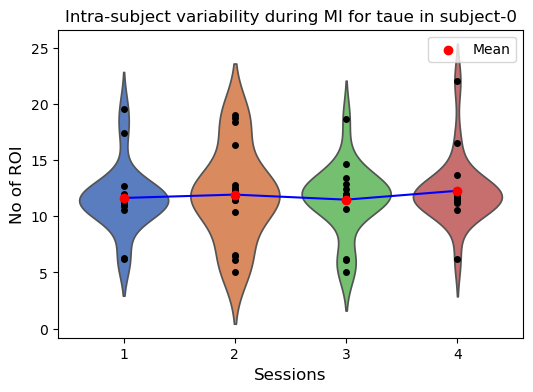

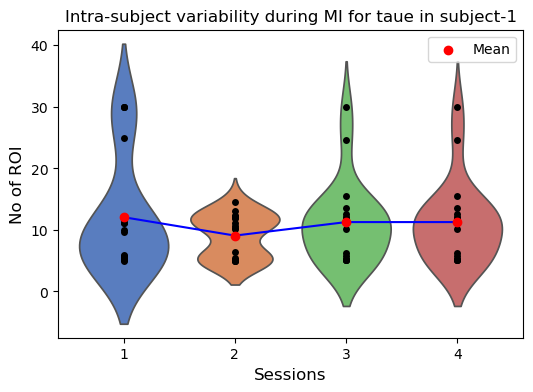

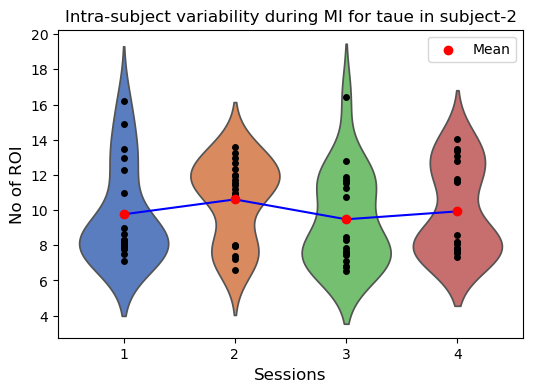

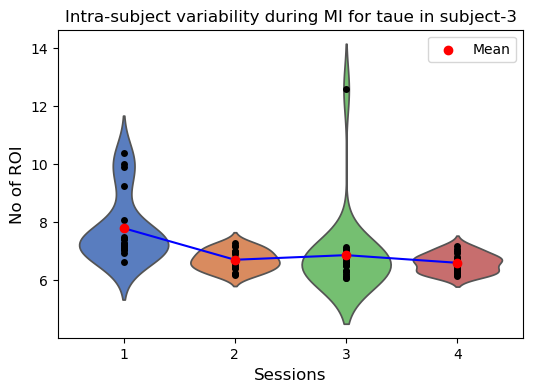

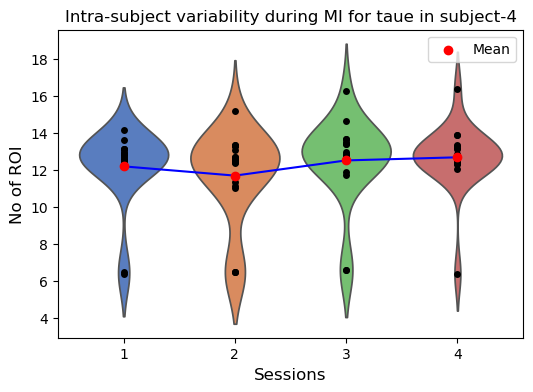

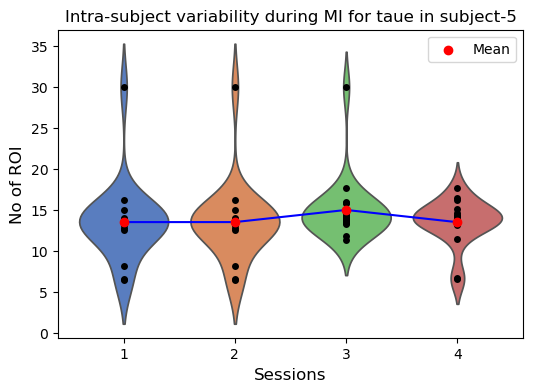

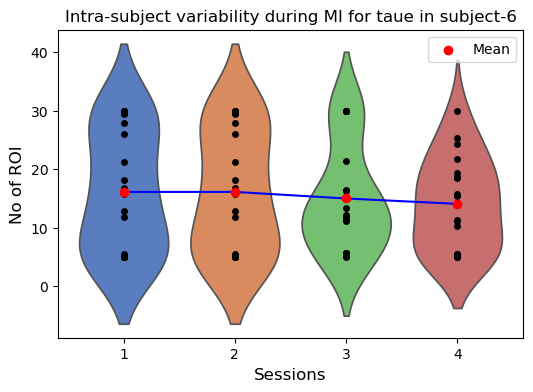

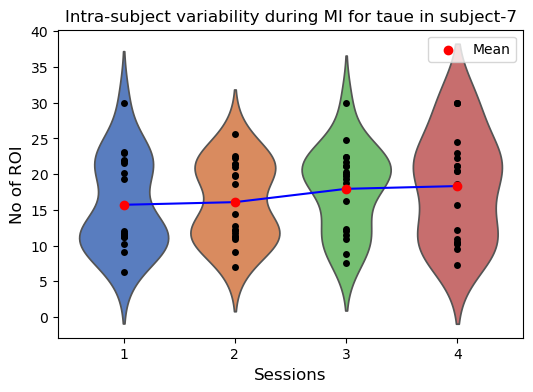

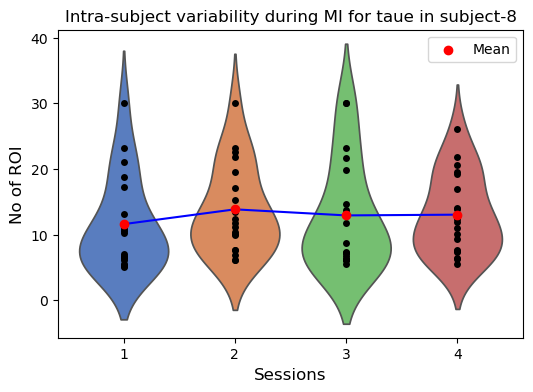

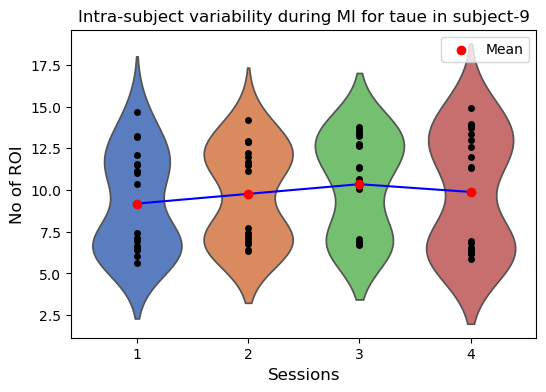

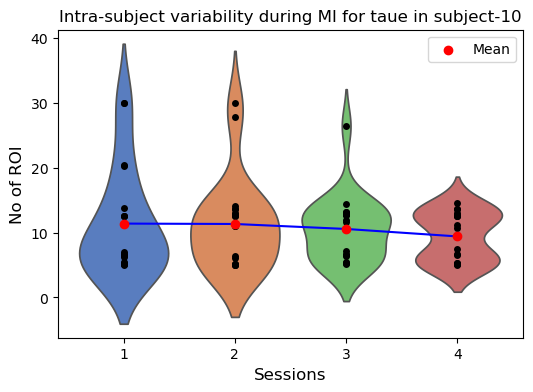

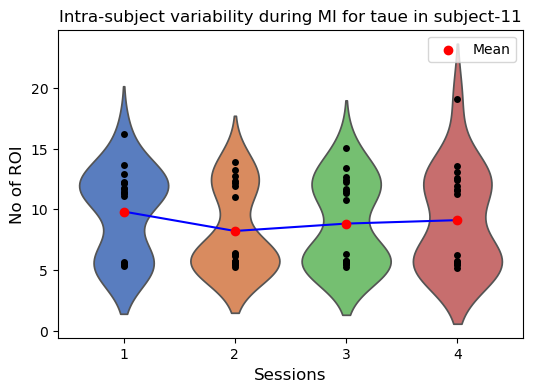

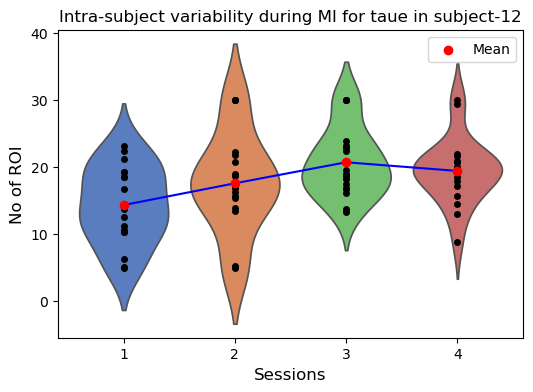

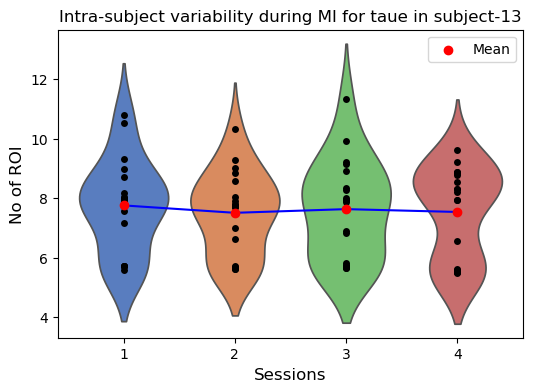

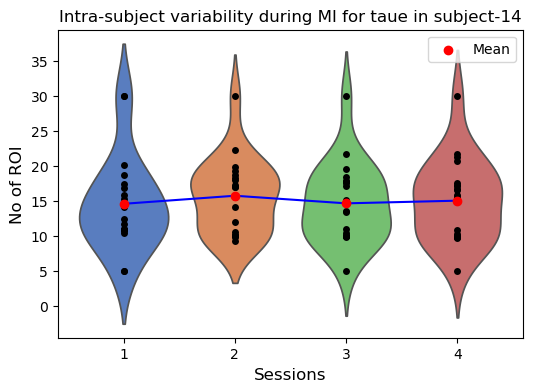

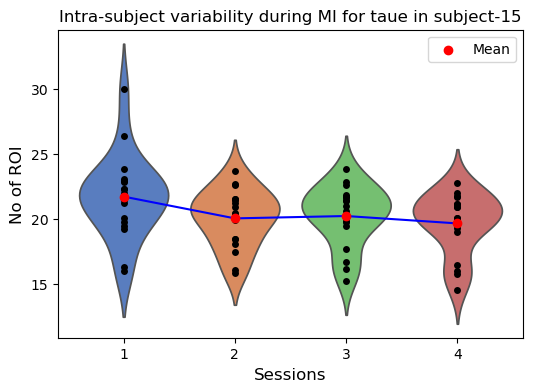

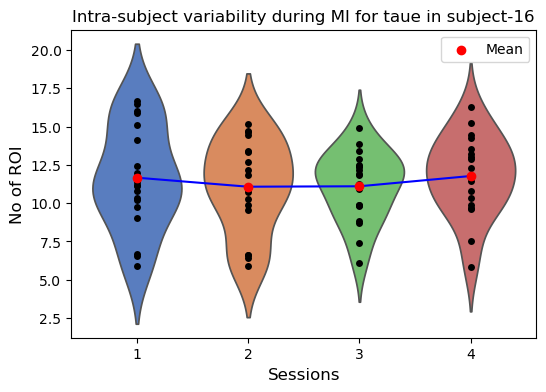

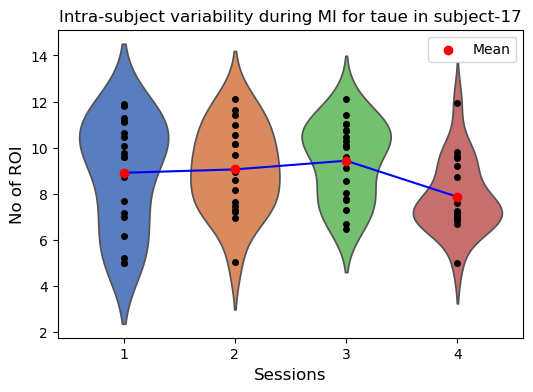

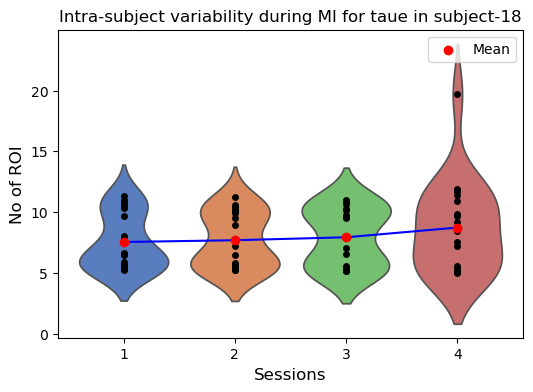

In [42]:

##for tau_e--(MI-Rest)/Rest
def main():
    for i in range(19):
      data = [sess1_mi_rest_tau_e[i],sess2_mi_rest_tau_e[i],sess3_mi_rest_tau_e[i],sess4_mi_rest_tau_e[i]]
      means = find_mean(data)
      parameter="No of ROI"
      state="MI"
      plot_violin(data, means, parameter, i ,state)

if __name__ == "__main__":
    main()
